<a href="https://colab.research.google.com/github/ubermenchh/chotagrad/blob/main/modern_compvis_pytorch_book/facial_key_point_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Key Point Detection

In [1]:
!pip install -q torchsummary

In [2]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset, DataLoader, Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import cluster
%matplotlib inline

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 6049 (delta 3), reused 3 (delta 0), pack-reused 6038
Receiving objects: 100% (6049/6049), 329.53 MiB | 35.31 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [4]:
root_dir = '/content/P1_Facial_Keypoints/data/training'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('/content/P1_Facial_Keypoints/data/training_frames_keypoints.csv')

In [5]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [19]:
class FacesData(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        img_path = '/content/P1_Facial_Keypoints/data/training/' + self.df.iloc[idx, 0]
        img = cv2.imread(img_path) / 255.
        kp = deepcopy(self.df.iloc[idx, 1:].tolist())
        kp_x = (np.array(kp[0::2]) / img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2]) / img.shape[0]).tolist()

        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2

    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img.to(device)

    def load_img(self, idx):
        img_path = '/content/P1_Facial_Keypoints/data/training/' + self.df.iloc[idx, 0]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.
        img = cv2.resize(img, (224, 224))
        return img

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [25]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.Sequential(
    nn.Conv2d(512, 512, 3),
    nn.MaxPool2d(2),
    nn.Flatten()
)

model.classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 136),
    nn.Sigmoid()
)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

def validate_batch(img, kps, model, criterion):
    model.eval()
    with torch.no_grad():
        _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

In [28]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img, kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix + 1)

    for ix, (img, kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix + 1)

    print(f"Epoch {epoch+1}/50 -> Train Loss - {epoch_train_loss:.3f} | Test Loss - {epoch_test_loss:.3f}")

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

Epoch 1/50 -> Train Loss - 0.059 | Test Loss - 0.037
Epoch 2/50 -> Train Loss - 0.041 | Test Loss - 0.030
Epoch 3/50 -> Train Loss - 0.035 | Test Loss - 0.026
Epoch 4/50 -> Train Loss - 0.031 | Test Loss - 0.026
Epoch 5/50 -> Train Loss - 0.029 | Test Loss - 0.024
Epoch 6/50 -> Train Loss - 0.028 | Test Loss - 0.023
Epoch 7/50 -> Train Loss - 0.026 | Test Loss - 0.022
Epoch 8/50 -> Train Loss - 0.025 | Test Loss - 0.023
Epoch 9/50 -> Train Loss - 0.024 | Test Loss - 0.023
Epoch 10/50 -> Train Loss - 0.024 | Test Loss - 0.023
Epoch 11/50 -> Train Loss - 0.023 | Test Loss - 0.022
Epoch 12/50 -> Train Loss - 0.022 | Test Loss - 0.021
Epoch 13/50 -> Train Loss - 0.021 | Test Loss - 0.022
Epoch 14/50 -> Train Loss - 0.021 | Test Loss - 0.021
Epoch 15/50 -> Train Loss - 0.020 | Test Loss - 0.020
Epoch 16/50 -> Train Loss - 0.020 | Test Loss - 0.021
Epoch 17/50 -> Train Loss - 0.020 | Test Loss - 0.021
Epoch 18/50 -> Train Loss - 0.019 | Test Loss - 0.021
Epoch 19/50 -> Train Loss - 0.019 | T

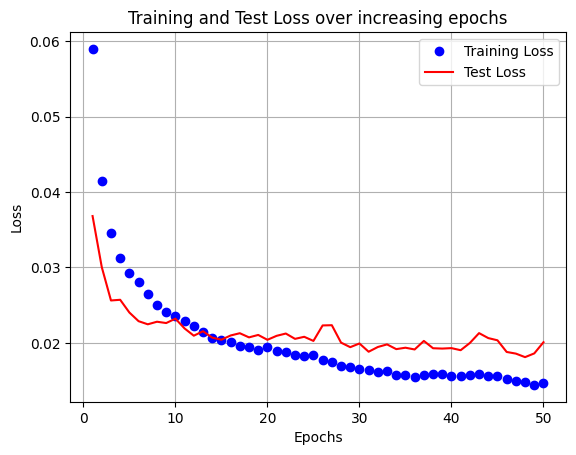

In [29]:
epochs = np.arange(50) + 1
import matplotlib.ticker as mtick
plt.plot(epochs, train_loss, 'bo', label="Training Loss")
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title('Training and Test Loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()
plt.grid('off')
plt.show()

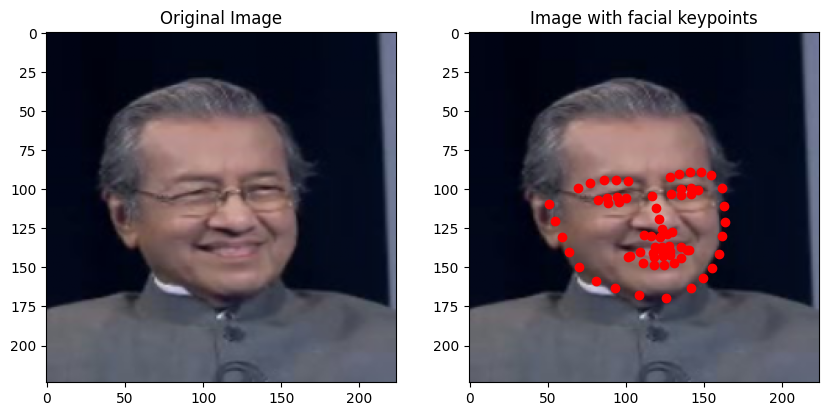

In [30]:
ix = 0
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title('Original Image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

# 2D & 3D Facial Key Point Detection